In [ ]:
import tensorflow as tf 
import tensorflow_datasets as tfds 
import datetime
import tqdm
import matplotlib.pyplot as plt
%load_ext tensorboard

In [ ]:
(train_data, test_data) = tfds.load('mnist', split = ['train', 'test'], as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def preprocessing(mnist, noise=1):
  mnist = mnist.map(lambda x,y: x)
  mnist = mnist.map(lambda x: tf.cast(x, tf.float32)) 
  mnist = mnist.map(lambda x: (x/255.))
  #mnist = mnist.map(lambda x: tf.image.grayscale_to_rgb(tf.expand_dims(x, -1)))
  #mnist = mnist.map(lambda x: tf.expand_dims(x, -1))
  #mnist = mnist.map(lambda x: tf.reshape(x, [28, 28, 3])) this is not possible, as not enough values 
  #adding normally ditributed noise, making sure values are between 0 and 1
  mnist = mnist.map(lambda x: (tf.clip_by_value( x + noise * tf.random.normal(tf.shape(x)), clip_value_min = 0, clip_value_max = 1), x))

  mnist = mnist.cache()

  mnist = mnist.shuffle(2011).batch(44).prefetch(21) 

  return mnist


In [ ]:
train_ds = preprocessing(train_data, 0.6)
test_ds = preprocessing(test_data, 0.6)

In [ ]:
# check the shapes of input and targets
for x,y in train_ds.take(1):
    print(x.shape)
    #print(tf.cast(tf.floor(x*255), tf.uint32)[1,:,:,:])
    print(type(x))
    #print(y.shape)
    #print(y)

(44, 28, 28, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>


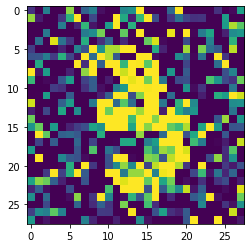

In [ ]:
for x,y in train_ds.take(1):
  img = tf.cast(tf.floor(x*255), tf.uint32)[1,:,:,-1]
  fig, ax = plt.subplots()
  img = ax.imshow(img)
  plt.show()

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        
        #basic CNN structure to convert mnist matrix into a vector
        self.cnn_list = [tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='valid', strides=(2,2), activation='relu'),
                         tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='valid', strides=(2,2), activation='relu'),
                         tf.keras.layers.GlobalMaxPool2D(),
                         tf.keras.layers.Dense(10, activation='sigmoid')]



    def call(self, x, training=False):
      for layer in self.cnn_list:
        x = layer(x)
      return x

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__() 

    self.transposed_cnn_list = [tf.keras.layers.Dense(7*7*4), 
                                tf.keras.layers.Reshape((7,7,4)),
                                tf.keras.layers.Conv2DTranspose(filters = 24, kernel_size = 3, padding = 'valid', strides=(2,2), activation='relu'),
                                tf.keras.layers.Conv2DTranspose(filters = 24, kernel_size = 3, padding = 'valid', strides=(2,2), activation='relu'),
                                tf.keras.layers.Conv2D(filters = 1, kernel_size = 4, activation='sigmoid')]

  def call(self, x, training = False):
    for layer in self.transposed_cnn_list:
      x = layer(x) 
    return x

In [ ]:
class Autoencoder(tf.keras.Model):
  def __init__(self):
    super(Autoencoder, self).__init__() 


    # just metrics as we use model.compile no optimizer, loss function needed
    self.metrics_list = [tf.keras.metrics.BinaryAccuracy(name = "accuracy"),
                         tf.keras.metrics.Mean(name = "loss")]
                         
    #Reconstruction Loss: The loss function we use to train the autoencoder is highly dependent on the type of input and output we want the autoencoder to adapt to. 
    #If we are working with image data, the most popular loss functions for reconstruction are MSE Loss and L1 Loss. 
    #In case the inputs and outputs are within the range [0,1], as in MNIST, we can also make use of Binary Cross Entropy as the reconstruction loss.

    self.optimizer = tf.keras.optimizers.Adam()
    self.loss_function = tf.keras.losses.BinaryCrossentropy()

    self.outputs = None

    self.encoder = Encoder() 
    self.decoder = Decoder()

  def call(self, x, training = False):
    x = self.encoder(x) 
    x = self.decoder(x)

    return x

 # 3. metrics property 

  @property
  def metrics(self):
    return self.metrics_list 

  # 4. reset all metrics objects 
  def reset_metrics(self):
    for metric in self.metrics:
      metric.reset_states() 

  # some getter functions to reuse some creations of this Autoencoder
  def get_output(self): 
    return self.outputs

  def get_encoder(self):
    return self.encoder

  # 5. train step method  
  def train_step(self, data): 
    img, label = data 

    with tf.GradientTape() as tape:
      output = self(img, training = True) 
      self.outputs = output
      loss = self.loss_function(label, output) 

    gradients = tape.gradient(loss, self.trainable_variables) 

    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    

    #update state of metrics acccording to loss
    self.metrics[0].update_state(label, output)
    self.metrics[1].update_state(loss) 

    #return dictionary with metric names as keys and metric results as values
    return {m.name : m.result() for m in self.metrics}

  def test_step(self, data):
    img, label = data 
    #same as train_step without paameters updates
    output = self(img, training = False)
    loss = self.loss_function(label, output)

    #update the state of the metrics according to loss
    self.metrics[0].update_state(label, output)
    self.metrics[1].update_state(loss)

    #return a dictionary with metric names as keys and metric results as values 
    return {"val_" + m.name : m.result() for m in self.metrics}


In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"drive/MyDrive/logs/"

val_log_path = f"drive/MyDrive/logs/"

train_summary_writer = tf.summary.create_file_writer(train_log_path + current_time)

val_summary_writer = tf.summary.create_file_writer(val_log_path + current_time)

In [ ]:
def training_loop(model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path): 
  # 1. iterate over epochs
  for epoch in range(epochs):

    #outputs = []
    #noisy_image = []
    loopCounter = 0

    # 2. train step over all batches in training data
    for data in tqdm.tqdm(train_ds):
      metrics = model.train_step(data)

      #collect some in- and outputs:
      if loopCounter % 1000 == 0:
        img, label = data
        noisy_image = tf.cast(tf.floor(img*255), tf.uint32)[1,:,:,-1]
        outputs = model.get_output()
        #output_image = tf.cast(tf.floor(outputs*255), tf.uint32)[1,:,:,-1]
        fig, ax = plt.subplots(nrows=2, ncols=1)
        noisy_image = ax[0].imshow(noisy_image)
        output_image = ax[1].imshow(outputs[1,:,:,-1])

        plt.show()

      loopCounter += 1


    # 3. log and print training metrics 
    with train_summary_writer.as_default():
      tf.summary.scalar(name = "accuracy", data = metrics["accuracy"], step = epoch)
      tf.summary.scalar(name = "loss", data = metrics["loss"], step = epoch)

    print(metrics.items())

    # 4. rest metrics
    model.reset_metrics()

    # 5. evaluate on validation data
    for data in val_ds:
      metrics = model.test_step(data)

    # 6. log validation metric 
    with val_summary_writer.as_default():
      tf.summary.scalar(name = "val_accuracy", data = metrics["val_accuracy"], step = epoch)
      tf.summary.scalar(name = "val_loss", data = metrics["val_loss"], step = epoch)

    print(metrics.items())

    # 7. reset metric objects
    model.reset_metrics()

  #8. save models weights
  model.save_weights(save_path)

  0%|          | 0/1364 [00:00<?, ?it/s]

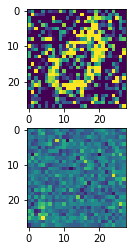

 73%|███████▎  | 1000/1364 [02:12<00:48,  7.57it/s]

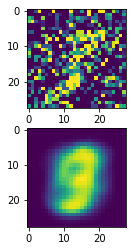

100%|██████████| 1364/1364 [03:21<00:00,  6.75it/s]


dict_items([('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.8060086>), ('loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.26710227>)])
dict_items([('val_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.7967421>), ('val_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.2513438>)])


  0%|          | 0/1364 [00:00<?, ?it/s]

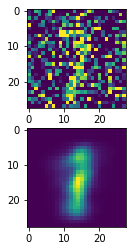

 73%|███████▎  | 1000/1364 [02:09<00:45,  8.02it/s]

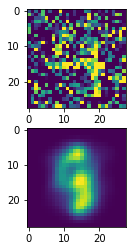

100%|██████████| 1364/1364 [03:21<00:00,  6.76it/s]


dict_items([('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79445994>), ('loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.24722849>)])
dict_items([('val_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79246163>), ('val_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.24473056>)])


  0%|          | 0/1364 [00:00<?, ?it/s]

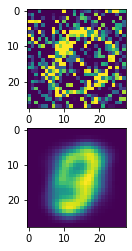

 73%|███████▎  | 1000/1364 [02:08<00:45,  7.96it/s]

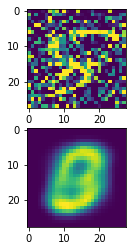

100%|██████████| 1364/1364 [02:54<00:00,  7.81it/s]


dict_items([('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79411495>), ('loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.24324119>)])
dict_items([('val_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.793257>), ('val_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.24190041>)])


  0%|          | 0/1364 [00:00<?, ?it/s]

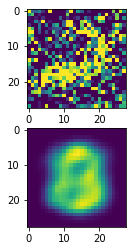

 73%|███████▎  | 1000/1364 [02:09<00:45,  8.02it/s]

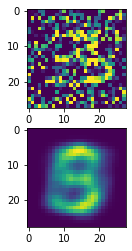

100%|██████████| 1364/1364 [03:21<00:00,  6.76it/s]


dict_items([('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79420185>), ('loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.24108566>)])
dict_items([('val_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79208434>), ('val_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.24028502>)])


  0%|          | 0/1364 [00:00<?, ?it/s]

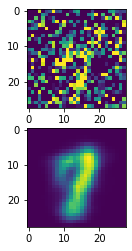

 73%|███████▎  | 1000/1364 [02:05<00:46,  7.82it/s]

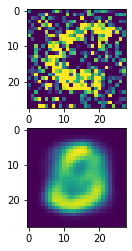

100%|██████████| 1364/1364 [03:21<00:00,  6.76it/s]


dict_items([('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79452187>), ('loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23901364>)])
dict_items([('val_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.7903742>), ('val_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23881091>)])


  0%|          | 0/1364 [00:00<?, ?it/s]

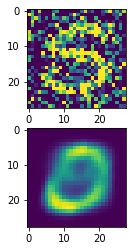

 73%|███████▎  | 1000/1364 [02:05<00:45,  8.01it/s]

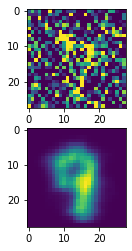

100%|██████████| 1364/1364 [02:51<00:00,  7.97it/s]


dict_items([('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.7948673>), ('loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23689456>)])
dict_items([('val_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79645944>), ('val_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23609868>)])


  0%|          | 0/1364 [00:00<?, ?it/s]

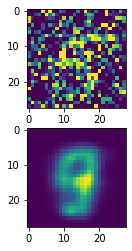

 73%|███████▎  | 1000/1364 [02:08<00:45,  7.92it/s]

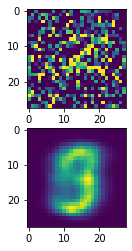

100%|██████████| 1364/1364 [03:21<00:00,  6.76it/s]


dict_items([('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79485655>), ('loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23528464>)])
dict_items([('val_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79264706>), ('val_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23497939>)])


  0%|          | 0/1364 [00:00<?, ?it/s]

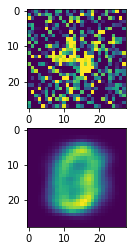

 73%|███████▎  | 1000/1364 [02:10<00:45,  8.03it/s]

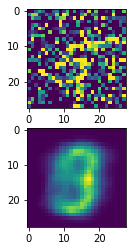

100%|██████████| 1364/1364 [03:21<00:00,  6.76it/s]


dict_items([('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.7948434>), ('loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23382737>)])
dict_items([('val_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79595524>), ('val_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23315644>)])


  0%|          | 0/1364 [00:00<?, ?it/s]

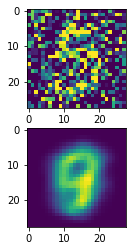

 73%|███████▎  | 1000/1364 [02:08<01:33,  3.90it/s]

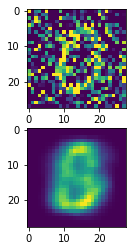

100%|██████████| 1364/1364 [03:21<00:00,  6.76it/s]


dict_items([('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.7948258>), ('loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.2325604>)])
dict_items([('val_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79414487>), ('val_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23206645>)])


  0%|          | 0/1364 [00:00<?, ?it/s]

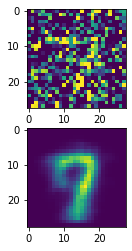

 73%|███████▎  | 1000/1364 [02:06<00:46,  7.89it/s]

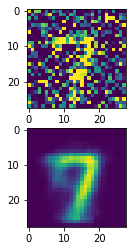

100%|██████████| 1364/1364 [02:52<00:00,  7.89it/s]


dict_items([('accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.7948735>), ('loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23161593>)])
dict_items([('val_accuracy', <tf.Tensor: shape=(), dtype=float32, numpy=0.79687464>), ('val_loss', <tf.Tensor: shape=(), dtype=float32, numpy=0.23205933>)])


In [ ]:
# 1. instantiate model
model = Autoencoder()

# 2. choose a path to save weights
save_path = "drive/MyDrive/trained_model/Autoencoder"

# 3. pass arguments to training loop function
training_loop(model, train_ds, test_ds, 10, train_summary_writer, val_summary_writer, save_path)

In [ ]:
# 2. choose a path to save weights
save_path = "drive/MyDrive/trained_model/Autoencoder"

loaded_model = Autoencoder() 

inp= tf.keras.Input((28,28,1))
loaded_model(inp) 

loaded_model.load_weights(save_path)

In [ ]:
#visualization thanks to: https://ranasinghiitkgp.medium.com/t-sne-visualization-of-high-dimension-mnist-dataset-48fb23d1bafd

from sklearn.manifold import TSNE 

test_data_TSNE = test_data.take(1000)
data_TSNE= test_data_TSNE.map(lambda x,y: tf.cast(tf.expand_dims(x, 0), tf.float32))
label_TSNE = test_data_TSNE.map(lambda x,y: tf.cast(y, tf.float32))

tsne_model = loaded_model.get_encoder()

# create embedding via loop function
embedding = []
for x in data_TSNE:
  embedding.append(tf.squeeze(tsne_model.call(x)))

#adjust type of labels
labels = [] 
for y in label_TSNE.take(1000):
  labels.append(y)

label_TSNE = labels

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn

print(np.shape(embedding))
print(np.shape(label_TSNE))
print(embedding[0])


(1000, 10)
(1000,)
tf.Tensor([1. 0. 1. 1. 1. 1. 1. 1. 1. 0.], shape=(10,), dtype=float32)


In [ ]:
model_TSNE = TSNE(n_components = 2, random_state = 0) 

tsne_data = model_TSNE.fit_transform(embedding)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


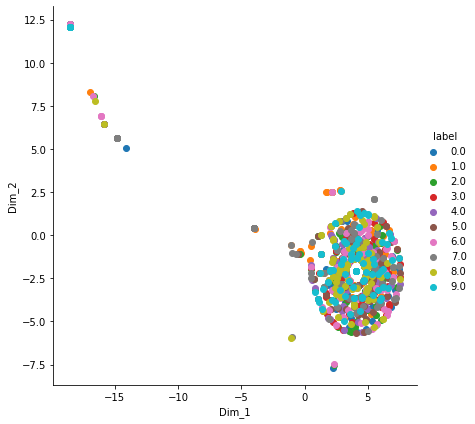

In [ ]:
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label_TSNE)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue='label', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()